In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='-1'
import tensorflow.compat.v1 as tf
from tensorflow.contrib.opt import ScipyOptimizerInterface
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
import random
import sys
np.set_printoptions(threshold=sys.maxsize)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [2]:
class DNN:
    def __init__(self):
        pass
    
    def hyper_initial(self, layers):
        L = len(layers)
        W = []
        b = []
        for l in range(1, L):
            in_dim = layers[l-1]
            out_dim = layers[l]
            std = np.sqrt(2/(in_dim + out_dim))
            weight = tf.Variable(tf.random_normal(shape=[in_dim, out_dim], stddev=std))
            bias = tf.Variable(tf.zeros(shape=[1, out_dim]))
            W.append(weight)
            b.append(bias)

        return W, b

    def fnn(self, W, b, X, Xmin, Xmax):
        A = 2.0*(X - Xmin)/(Xmax - Xmin) - 1.0
        L = len(W)
        for i in range(L-1):
            A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
        Y = tf.add(tf.matmul(A, W[-1]), b[-1])
        
        return Y


In [3]:
n = 0
def callback(loss_):
    global n
    n += 1
    if n%1000 == 0:
        print('n: %d, loss: %.3e'%(n, loss_))

In [4]:
YH1_train = np.genfromtxt('Vis_Train_H.txt')
XH1_train = np.genfromtxt('ExT_Train_H.txt')
XH2_train = np.genfromtxt('Shr_Train_H.txt')

YH1_train = YH1_train.reshape((-1,1))
XH1_train = XH1_train.reshape((-1,1))
XH2_train = XH2_train.reshape((-1,1))

In [5]:
YH1_test = np.genfromtxt('Vis_Test_H.txt')
XH1_test = np.genfromtxt('ExT_Test_H.txt')
XH2_test = np.genfromtxt('Shr_Test_H.txt')

YH1_test = YH1_test.reshape((-1,1))
XH1_test = XH1_test.reshape((-1,1))
XH2_test = XH2_test.reshape((-1,1))

In [6]:
y_hf = YH1_train.reshape(1,-1).T
x_hf = XH1_train.reshape(1,-1).T
t_hf = XH2_train.reshape(1,-1).T

X_hf = np.hstack((x_hf,t_hf))

Xmin = X_hf.min(0)
Xmax = X_hf.max(0)
Ymin = y_hf.min(0)
Ymax = y_hf.max(0)

Xhmin = np.hstack((Xmin, Ymin))
Xhmax = np.hstack((Xmax, Ymax))

In [7]:
D = 2
layers_hf = [D] + 2*[20] + [1]

x_train_hf = tf.placeholder(shape=[None, D], dtype=tf.float32)
y_train_hf = tf.placeholder(shape=[None, 1], dtype=tf.float32)

In [8]:
model = DNN()
W_hf, b_hf = model.hyper_initial(layers_hf)
y_pred_hf = model.fnn(W_hf, b_hf, x_train_hf, Xmin, Xmax)

In [9]:
loss = tf.reduce_mean((tf.square(y_pred_hf - y_train_hf)))
train_adam = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)
train_lbfgs = ScipyOptimizerInterface(loss,
                                      method = 'L-BFGS-B', 
                                      options={'maxiter': 50000,
                                               'ftol': 1.0*np.finfo(float).eps
                                              })

In [10]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

### Compile the cell below just only for model loading

In [11]:
#model = saver.restore(sess, 'DNNModel/DNNModel')

In [12]:
nmax1 = 2000
nmax2 = 20000
loss_c = 1.0e-6
loss_ = 1.0
train_dict = {x_train_hf: X_hf, y_train_hf: y_hf}
print('Adam Optimizer')
while n < nmax1 and loss_ > loss_c:
    n += 1
    loss_, _ = sess.run([loss, train_adam], feed_dict=train_dict)
    if n%1000 == 0:
        print('n: %d, loss: %.3e'%(n, loss_))
        saved_path = saver.save(sess, 'DNNModel/DNNModel')

print('LBFG-S Optimizer')
train_lbfgs.minimize(sess, feed_dict=train_dict, fetches=[loss], loss_callback=callback)

print('Adam Optimizer')
while n < nmax2 and loss_ > loss_c:
    n += 1
    loss_, _ = sess.run([loss, train_adam], feed_dict=train_dict)
    if n%1000 == 0:
        print('n: %d, loss: %.3e'%(n, loss_))
        saved_path = saver.save(sess, 'DNNModel/DNNModel')

print('LBFG-S Optimizer')
train_lbfgs.minimize(sess, feed_dict=train_dict, fetches=[loss], loss_callback=callback)

print("Training is done!")

Adam Optimizer
n: 1000, loss: 1.233e-02
n: 2000, loss: 1.194e-02
LBFG-S Optimizer
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 0.010834
  Number of iterations: 844
  Number of functions evaluations: 994
Adam Optimizer
n: 3000, loss: 1.286e-02
n: 4000, loss: 1.083e-02
n: 5000, loss: 1.083e-02
n: 6000, loss: 1.082e-02
n: 7000, loss: 1.082e-02
n: 8000, loss: 1.081e-02
n: 9000, loss: 1.081e-02
n: 10000, loss: 1.080e-02
n: 11000, loss: 1.080e-02
n: 12000, loss: 1.079e-02
n: 13000, loss: 1.079e-02
n: 14000, loss: 1.078e-02
n: 15000, loss: 1.076e-02
n: 16000, loss: 1.074e-02
n: 17000, loss: 1.072e-02
n: 18000, loss: 1.069e-02
n: 19000, loss: 1.065e-02
n: 20000, loss: 1.059e-02
LBFG-S Optimizer
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 0.010595
  Number of iterations: 2
  Number of functions evaluations: 16
Trai

In [13]:
x_test_h = XH1_test.reshape((-1, 1))
t_test_h = XH2_test.reshape((-1, 1))

X_test_h = np.hstack((x_test_h,t_test_h))

y_hf_ref = YH1_test.reshape((-1, 1))
y_hf_test = sess.run(y_pred_hf, feed_dict={x_train_hf: X_test_h})

In [14]:
np.savetxt('Results/ShR.txt', XH2_test)
np.savetxt('Results/Y_D.txt', y_hf_test)

# Flow Curve

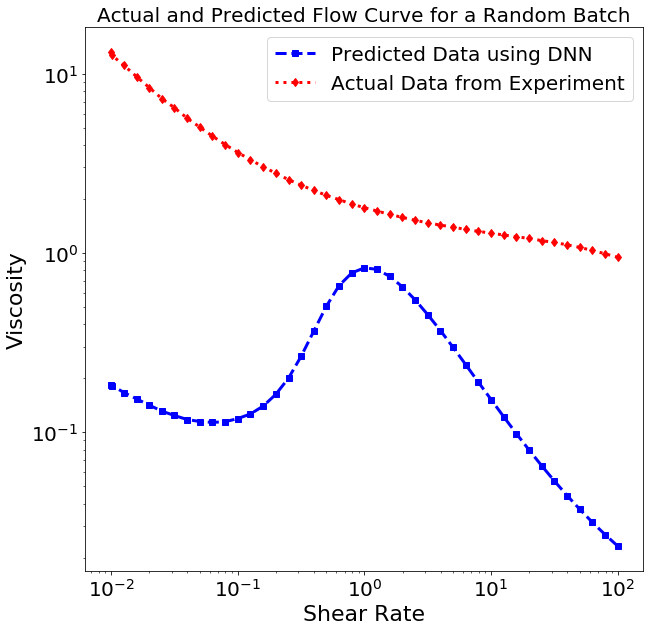

In [15]:
a=0*42
b=1*42

ShR = np.power(10,XH2_test[a:b])

plt.figure(figsize=(10,10))

plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=22)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=22)  # fontsize of the figure title

plt.plot(ShR,np.power(10,y_hf_test[a:b]), 'bs--', linewidth=3.0)
plt.plot(ShR,np.power(10,y_hf_ref[a:b]) , 'rd:', linewidth=3.0)

plt.xlabel('Shear Rate')
plt.ylabel('Viscosity')
plt.legend(['Predicted Data using DNN','Actual Data from Experiment'])
plt.title('Actual and Predicted Flow Curve for a Random Batch')

plt.xscale("log")
plt.yscale("log")

plt.show()

# Regression

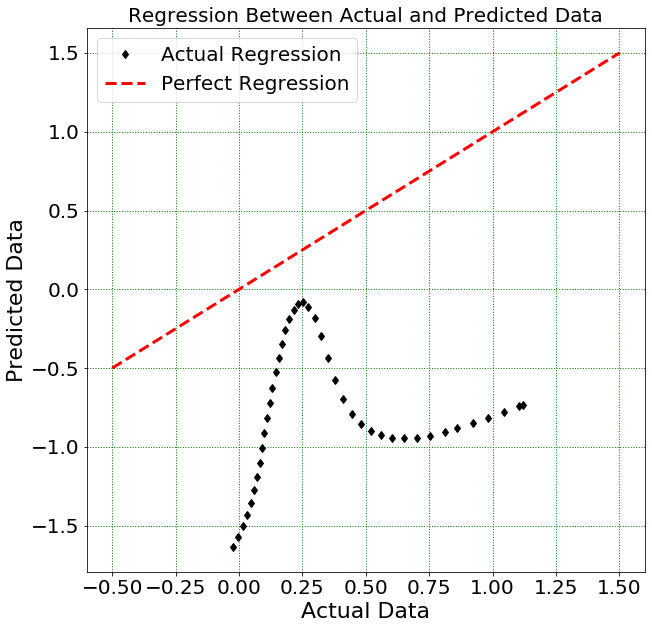

In [16]:
plt.figure(figsize=(10,10))

plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=22)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=22)  # fontsize of the figure title

plt.plot(y_hf_ref,y_hf_test, 'kd', linewidth=5.0)
plt.plot(np.linspace(-0.5, 1.5, 100),np.linspace(-0.5, 1.5, 100), 'r--', linewidth=3.0)
plt.xlabel('Actual Data')
plt.ylabel('Predicted Data')
plt.legend(['Actual Regression','Perfect Regression'])
plt.title('Regression Between Actual and Predicted Data')

plt.grid(color='g', linestyle=':', linewidth=1)

#plt.xlim(-0.5, 1.5)
#plt.ylim(-0.5, 1.5)

#plt.text(-4500, 11500, 'Pearson Regression Correlation is 0.94', style='italic',bbox={'facecolor': 'blue', 'alpha': 0.1, 'pad': 5})
#plt.savefig('00 Research Codes/02_Multi_Fidelity/With_Randy/FX1_linear_regression.png')

plt.show()